In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr30k/captions.txt
/kaggle/input/flickr30k/Images/2715746315.jpg
/kaggle/input/flickr30k/Images/3463034205.jpg
/kaggle/input/flickr30k/Images/268704620.jpg
/kaggle/input/flickr30k/Images/2673564214.jpg
/kaggle/input/flickr30k/Images/7535037918.jpg
/kaggle/input/flickr30k/Images/4912369161.jpg
/kaggle/input/flickr30k/Images/4828071602.jpg
/kaggle/input/flickr30k/Images/6802728196.jpg
/kaggle/input/flickr30k/Images/3346289227.jpg
/kaggle/input/flickr30k/Images/3217056901.jpg
/kaggle/input/flickr30k/Images/272471327.jpg
/kaggle/input/flickr30k/Images/4717261252.jpg
/kaggle/input/flickr30k/Images/4763916790.jpg
/kaggle/input/flickr30k/Images/2700788458.jpg
/kaggle/input/flickr30k/Images/2795287622.jpg
/kaggle/input/flickr30k/Images/4453893059.jpg
/kaggle/input/flickr30k/Images/2094323311.jpg
/kaggle/input/flickr30k/Images/2375770917.jpg
/kaggle/input/flickr30k/Images/5962278982.jpg
/kaggle/input/flickr30k/Images/2460568004.jpg
/kaggle/input/flickr30k/Images/2567962271.jpg

# Libraries needed 

In [2]:
import numpy as np
import pandas as pd
import os
import random
import pickle
from collections import Counter

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# NLP
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.translate.meteor_score import meteor_score

try:
    nltk.data.find('wordnet')
except LookupError:
    nltk.download('wordnet')
    nltk.download('omw-1.4')

# Metrics
from sklearn.metrics import precision_recall_fscore_support

# Image
from PIL import Image

# Utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Warnings
import warnings
warnings.filterwarnings('ignore')

print(" All libraries imported successfully")


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


 All libraries imported successfully


# Device Config

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

if torch.cuda.device_count() > 0:
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")

Device: cuda
CUDA available: True
Number of GPUs: 2
  GPU 0: Tesla T4
  GPU 1: Tesla T4


# Locate Dataset

In [4]:
def find_image_dir():
    base = "/kaggle/input"
    for root, dirs, files in os.walk(base):
        jpgs = [f for f in files if f.endswith(".jpg")]
        if len(jpgs) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
print(f" Found images at: {IMAGE_DIR}")

 Found images at: /kaggle/input/flickr30k/Images


# Feature Extraction

In [5]:
OUTPUT_FILE = "flickr30k_features.pkl"

class FlickrImageDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.images = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        return self.transform(image), img_name

# ResNet-50

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

dataset = FlickrImageDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)

# Load ResNet50
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet = nn.Sequential(*list(resnet.children())[:-1])

if torch.cuda.device_count() > 1:
    print(f" Using {torch.cuda.device_count()} GPUs for feature extraction!")
    resnet = nn.DataParallel(resnet)  # ← DUAL GPU ENABLED HERE
else:
    print("Using single GPU for feature extraction")

resnet = resnet.to(device)
resnet.eval()

print(" ResNet-50 loaded successfully with GPU support!")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s] 


 Using 2 GPUs for feature extraction!
 ResNet-50 loaded successfully with GPU support!


# Cache Images Features

In [7]:
features = {}

print("Extracting features using dual GPU...")
with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        imgs = imgs.to(device)
        feats = resnet(imgs).squeeze()
        
        # Handle single image case
        if len(feats.shape) == 1:
            feats = feats.unsqueeze(0)
        
        for i, name in enumerate(names):
            features[name] = feats[i].cpu().numpy()

with open(OUTPUT_FILE, "wb") as f:
    pickle.dump(features, f)

print(f" Extracted features for {len(features)} images")
print(f" Saved to {OUTPUT_FILE}")


Extracting features using dual GPU...


Extracting Features: 100%|██████████| 249/249 [01:57<00:00,  2.12it/s]


 Extracted features for 31783 images
 Saved to flickr30k_features.pkl


# Load captions

In [8]:
CAPTION_FILE = "/kaggle/input/flickr30k/captions.txt"

df = pd.read_csv(CAPTION_FILE)
print(f"Loaded {len(df)} captions")
df.head()

Loaded 158915 captions


image                                            caption
0  1000092795.jpg   Two young guys with shaggy hair look at their...
1  1000092795.jpg   Two young , White males are outside near many...
2  1000092795.jpg   Two men in green shirts are standing in a yard .
3  1000092795.jpg       A man in a blue shirt standing in a garden .
4  1000092795.jpg            Two friends enjoy time spent together .

# clean invalid caption

In [9]:
df = df[df["caption"].apply(lambda x: isinstance(x, str))].reset_index(drop=True)
print(f"After cleaning: {len(df)} valid captions")

After cleaning: 158914 valid captions


# Text Cleaning

In [10]:
def clean_caption(caption):
    """Clean and normalize caption text"""
    caption = caption.lower()
    
    # Remove special characters
    caption = caption.replace(".", "").replace(",", "")
    caption = caption.replace("!", "").replace("?", "")
    caption = caption.replace(";", "").replace(":", "")
    caption = caption.replace("(", "").replace(")", "")
    caption = caption.replace("[", "").replace("]", "")
    caption = caption.replace("-", " ").replace("_", " ")
    
    # Remove extra spaces
    caption = " ".join(caption.split())
    
    # Add start and end tokens
    caption = f"<start> {caption} <end>"
    
    return caption

# Apply cleaning
df["caption"] = df["caption"].apply(clean_caption)
print(" Captions cleaned")
print("\nSample cleaned captions:")
print(df["caption"].head())

 Captions cleaned

Sample cleaned captions:
0    <start> two young guys with shaggy hair look a...
1    <start> two young white males are outside near...
2    <start> two men in green shirts are standing i...
3    <start> a man in a blue shirt standing in a ga...
4    <start> two friends enjoy time spent together ...
Name: caption, dtype: object


# Build Vocabulary

In [11]:
all_words = []
for cap in df["caption"]:
    all_words.extend(cap.split())

# Count word frequencies
word_freq = Counter(all_words)
print(f"Total unique words (before filtering): {len(word_freq)}")

# Keep words that appear at least 5 times
MIN_WORD_FREQ = 5
vocab = [word for word, freq in word_freq.items() if freq >= MIN_WORD_FREQ]

# Add special tokens
special_tokens = ["<pad>", "<start>", "<end>", "<unk>"]
vocab = special_tokens + vocab

# Create mappings
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for idx, word in enumerate(vocab)}

vocab_size = len(vocab)
print(f" Vocabulary size: {vocab_size}")
print(f" Special tokens: {special_tokens}")
print(f"Sample words: {vocab[4:14]}")

# Save vocabulary for later use in app
with open("word2idx.pkl", "wb") as f:
    pickle.dump(word2idx, f)
with open("idx2word.pkl", "wb") as f:
    pickle.dump(idx2word, f)

print(" Vocabulary saved to word2idx.pkl and idx2word.pkl")

Total unique words (before filtering): 18354
 Vocabulary size: 7664
 Special tokens: ['<pad>', '<start>', '<end>', '<unk>']
Sample words: ['<start>', 'two', 'young', 'guys', 'with', 'shaggy', 'hair', 'look', 'at', 'their']
 Vocabulary saved to word2idx.pkl and idx2word.pkl


# Caption Datset

In [12]:
class CaptionDataset(Dataset):
    def __init__(self, df, features, word2idx, max_len=30):
        self.df = df
        self.features = features
        self.word2idx = word2idx
        self.max_len = max_len
        
        # Filter out images without features
        self.df = self.df[self.df['image'].isin(features.keys())].reset_index(drop=True)
        print(f"Dataset size: {len(self.df)} captions")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image']
        caption = row['caption']
        
        # Get image feature
        feature = self.features[img_name]
        feature = torch.tensor(feature, dtype=torch.float32)
        
        # Convert caption to indices
        tokens = caption.split()
        caption_indices = [self.word2idx.get(word, self.word2idx['<unk>']) for word in tokens]
        
        # Pad or truncate
        if len(caption_indices) < self.max_len:
            caption_indices += [self.word2idx['<pad>']] * (self.max_len - len(caption_indices))
        else:
            caption_indices = caption_indices[:self.max_len]
        
        caption_tensor = torch.tensor(caption_indices, dtype=torch.long)
        
        return feature, caption_tensor

# train/val split

In [13]:
train_df = df.sample(frac=0.8, random_state=SEED)
val_df = df.drop(train_df.index)

train_dataset = CaptionDataset(train_df, features, word2idx)
val_dataset = CaptionDataset(val_df, features, word2idx)

# Increased batch size for dual GPU
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

Dataset size: 127131 captions
Dataset size: 31783 captions
Train samples: 127131
Val samples: 31783


# Encoder

In [14]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.fc = nn.Linear(2048, embed_size)

    def forward(self, x):
        return self.fc(x)

# Decoder

In [15]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2, dropout=0.3):
        super().__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(
            embed_size, 
            hidden_size, 
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, captions, hidden):
        emb = self.embedding(captions)
        emb = self.dropout(emb)
        out, _ = self.lstm(emb, hidden)
        out = self.dropout(out)
        return self.fc(out)


# Model Wrapper

In [16]:
class ImageCaptionModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2):
        super().__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers=num_layers)
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.num_layers = num_layers  # ← STORE num_layers
        
        # Projection layer to map embed_size to hidden_size
        self.hidden_projection = nn.Linear(embed_size, hidden_size)
        
    def forward(self, features, captions):
        # Encode image features
        encoded = self.encoder(features)  # (batch, embed_size)
        
        # Project to hidden_size for LSTM
        projected = self.hidden_projection(encoded)  # (batch, hidden_size)
        
        # Initialize LSTM hidden state for ALL layers
        batch_size = features.size(0)
        
        # Repeat for num_layers (2 layers in your case)
        h = projected.unsqueeze(0).repeat(self.num_layers, 1, 1)  # ← FIXED! (num_layers, batch, hidden)
        c = torch.zeros_like(h)  # (num_layers, batch, hidden)
        
        # Decode
        outputs = self.decoder(captions[:, :-1], (h, c))
        
        return outputs
    
    def generate(self, features, max_len=30, method='greedy', beam_width=5):
        """Generate caption with greedy or beam search"""
        if len(features.shape) == 1:
            features = features.unsqueeze(0)
        
        if method == 'greedy':
            return self._greedy_search(features, max_len)
        elif method == 'beam':
            return self._beam_search(features, max_len, beam_width)
    
    def _get_modules(self):
        """Get actual modules (handles DataParallel wrapper)"""
        if isinstance(self, nn.DataParallel):
            return self.module.encoder, self.module.decoder, self.module.hidden_projection, self.module.num_layers
        else:
            return self.encoder, self.decoder, self.hidden_projection, self.num_layers
    
    def _greedy_search(self, features, max_len):
        """Greedy search decoding"""
        encoder, decoder, projection, num_layers = self._get_modules()
        
        self.eval()
        with torch.no_grad():
            encoded = encoder(features)
            projected = projection(encoded)
            
            # Initialize for num_layers
            h = projected.unsqueeze(0).repeat(num_layers, 1, 1)  # ← FIXED!
            c = torch.zeros_like(h)
            
            word = torch.tensor([[word2idx["<start>"]]]).to(features.device)
            caption = []
            
            for _ in range(max_len):
                emb = decoder.embedding(word)
                out, (h, c) = decoder.lstm(emb, (h, c))
                logits = decoder.fc(out.squeeze(1))
                pred = logits.argmax(1)
                word_id = pred.item()
                
                if idx2word[word_id] == "<end>":
                    break
                
                if idx2word[word_id] not in ["<start>", "<pad>"]:
                    caption.append(idx2word[word_id])
                
                word = pred.unsqueeze(1)
            
            return " ".join(caption)
    
    def _beam_search(self, features, max_len, beam_width):
        """Beam search decoding"""
        encoder, decoder, projection, num_layers = self._get_modules()
        
        self.eval()
        with torch.no_grad():
            encoded = encoder(features)
            projected = projection(encoded)
            
            # Initialize for num_layers
            h = projected.unsqueeze(0).repeat(num_layers, 1, 1)  # ← FIXED!
            c = torch.zeros_like(h)
            
            start_token = word2idx["<start>"]
            end_token = word2idx["<end>"]
            pad_token = word2idx["<pad>"]
            
            beams = [([start_token], 0.0, h, c)]
            completed = []
            
            for step in range(max_len):
                candidates = []
                
                for seq, score, h_state, c_state in beams:
                    if seq[-1] == end_token:
                        completed.append((seq, score))
                        continue
                    
                    word = torch.tensor([[seq[-1]]]).to(features.device)
                    emb = decoder.embedding(word)
                    out, (new_h, new_c) = decoder.lstm(emb, (h_state, c_state))
                    logits = decoder.fc(out.squeeze(1))
                    log_probs = torch.log_softmax(logits, dim=-1)
                    
                    top_probs, top_indices = log_probs[0].topk(beam_width)
                    
                    for prob, idx in zip(top_probs, top_indices):
                        new_seq = seq + [idx.item()]
                        new_score = score + prob.item()
                        candidates.append((new_seq, new_score, new_h, new_c))
                
                if not candidates:
                    break
                
                ordered = sorted(candidates, key=lambda x: x[1], reverse=True)
                beams = ordered[:beam_width]
            
            completed.extend(beams)
            if completed:
                best_seq, _ = max(completed, key=lambda x: x[1])
            else:
                best_seq = [start_token, end_token]
            
            caption = [idx2word[idx] for idx in best_seq 
                      if idx not in [start_token, end_token, pad_token]]
            
            return " ".join(caption)

# training setup 

In [17]:
EMBED_SIZE = 512
HIDDEN_SIZE = 1024

# Create model
model = ImageCaptionModel(EMBED_SIZE, HIDDEN_SIZE, vocab_size)

if torch.cuda.device_count() > 1:
    print(f"\n{'='*60}")
    print(f" Using {torch.cuda.device_count()} GPUs for training!")
    print(f"{'='*60}\n")
    model = nn.DataParallel(model)
else:
    print("Using single GPU")

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=5e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

# Print configuration
print(f"\n{'='*60}")
print(f"MODEL CONFIGURATION")
print(f"{'='*60}")
print(f"Embed size:        {EMBED_SIZE}")
print(f"Hidden size:       {HIDDEN_SIZE}")
print(f"Vocab size:        {vocab_size:,}")
print(f"Model parameters:  {sum(p.numel() for p in model.parameters()):,}")
print(f"Device:            {device}")

if torch.cuda.device_count() > 1:
    print(f"Training mode:     PARALLEL (Dual GPU)")
    print(f"GPUs in use:       {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print(f"Training mode:     Single GPU")
    print(f"GPUs in use:       1")

print(f"{'='*60}\n")


 Using 2 GPUs for training!


MODEL CONFIGURATION
Embed size:        512
Hidden size:       1024
Vocab size:        7,664
Model parameters:  28,050,416
Device:            cuda
Training mode:     PARALLEL (Dual GPU)
GPUs in use:       2
  GPU 0: Tesla T4
  GPU 1: Tesla T4



# training function

In [18]:
def train_epoch(loader):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(loader, desc="Training")
    for feats, caps in progress_bar:
        feats, caps = feats.to(device), caps.to(device)
        
        # Forward pass (automatically uses both GPUs with DataParallel)
        outputs = model(feats, caps)
        
        # Calculate loss
        loss = criterion(
            outputs.reshape(-1, vocab_size),
            caps[:, 1:].reshape(-1)
        )
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(loader)


def validate_epoch(loader):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for feats, caps in tqdm(loader, desc="Validating"):
            feats, caps = feats.to(device), caps.to(device)
            
            # Forward pass (automatically uses both GPUs)
            outputs = model(feats, caps)
            loss = criterion(
                outputs.reshape(-1, vocab_size),
                caps[:, 1:].reshape(-1)
            )
            
            total_loss += loss.item()
    
    return total_loss / len(loader)

# training loop

In [ ]:
EPOCHS = 60

train_losses = []
val_losses = []
best_val_loss = float('inf')

patience = 5  # Stop if no improvement for 5 epochs
min_delta = 0.001  # Minimum change to qualify as improvement
patience_counter = 0

print("Starting training...\n")

# Confirm dual GPU is active
if torch.cuda.device_count() > 1:
    print(f"✓ Training will use {torch.cuda.device_count()} GPUs in parallel")
    print(f"✓ Batch will be automatically split across GPUs\n")
else:
    print(f"⚠ Training on single GPU\n")

print(f"Early Stopping: Patience={patience}, Min Delta={min_delta}\n")

for epoch in range(EPOCHS):
    print(f"{'='*60}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"{'='*60}")
    
    # Show GPU memory on first epoch
    if epoch == 0 and torch.cuda.device_count() > 1:
        print(f"\nGPU Memory Usage:")
        for i in range(torch.cuda.device_count()):
            mem_allocated = torch.cuda.memory_allocated(i) / 1024**3
            mem_reserved = torch.cuda.memory_reserved(i) / 1024**3
            print(f"  GPU {i}: Allocated={mem_allocated:.2f}GB, Reserved={mem_reserved:.2f}GB")
        print()
    
    # Train
    train_loss = train_epoch(train_loader)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate_epoch(val_loader)
    val_losses.append(val_loss)
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    # Update learning rate
    old_lr = current_lr
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    
    improvement = best_val_loss - val_loss
    
    if improvement > min_delta:
        # Significant improvement
        best_val_loss = val_loss
        patience_counter = 0
        
        # Save the model (unwrap DataParallel if needed)
        model_to_save = model.module if isinstance(model, nn.DataParallel) else model
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_to_save.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'vocab_size': vocab_size,
            'embed_size': EMBED_SIZE,
            'hidden_size': HIDDEN_SIZE,
        }, 'best_model.pth')
        print(f"✓ Saved best model (val_loss: {val_loss:.4f}, improvement: {improvement:.4f})")
    else:
        # No improvement
        patience_counter += 1
        print(f"⚠ No improvement in validation loss ({patience_counter}/{patience})")
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Best Val:   {best_val_loss:.4f}")
    print(f"  Gap (Train-Val): {val_loss - train_loss:.4f}")
    print(f"  Learning Rate: {new_lr:.6f}")
    
    if old_lr != new_lr:
        print(f" Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}")
    
    if patience_counter >= patience:
        print(f"\n{'='*60}")
        print(f"EARLY STOPPING TRIGGERED!")
        print(f"{'='*60}")
        print(f"No improvement for {patience} epochs")
        print(f"Best validation loss: {best_val_loss:.4f} at epoch {epoch - patience + 1}")
        print(f"Stopping training early to prevent overfitting...")
        break
    
    print()

print("="*60)
print("TRAINING COMPLETED!")
print("="*60)
print(f"Total epochs trained: {len(train_losses)}")
if patience_counter >= patience:
    print(f"Stopped early (would have trained {EPOCHS} epochs)")
else:
    print(f"Completed all {EPOCHS} epochs")

Starting training...

✓ Training will use 2 GPUs in parallel
✓ Batch will be automatically split across GPUs

Early Stopping: Patience=5, Min Delta=0.001

Epoch 1/60

GPU Memory Usage:
  GPU 0: Allocated=0.21GB, Reserved=1.20GB
  GPU 1: Allocated=0.00GB, Reserved=1.16GB



Validating: 100%|██████████| 249/249 [00:14<00:00, 17.44it/s]


✓ Saved best model (val_loss: 3.8117, improvement: inf)

Epoch 1 Summary:
  Train Loss: 4.4086
  Val Loss:   3.8117
  Best Val:   3.8117
  Gap (Train-Val): -0.5969
  Learning Rate: 0.000200

Epoch 2/60


Validating: 100%|██████████| 249/249 [00:13<00:00, 17.90it/s]


✓ Saved best model (val_loss: 3.4784, improvement: 0.3333)

Epoch 2 Summary:
  Train Loss: 3.6911
  Val Loss:   3.4784
  Best Val:   3.4784
  Gap (Train-Val): -0.2127
  Learning Rate: 0.000200

Epoch 3/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.67it/s]


✓ Saved best model (val_loss: 3.3026, improvement: 0.1758)

Epoch 3 Summary:
  Train Loss: 3.4354
  Val Loss:   3.3026
  Best Val:   3.3026
  Gap (Train-Val): -0.1328
  Learning Rate: 0.000200

Epoch 4/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.40it/s]


✓ Saved best model (val_loss: 3.1951, improvement: 0.1075)

Epoch 4 Summary:
  Train Loss: 3.2901
  Val Loss:   3.1951
  Best Val:   3.1951
  Gap (Train-Val): -0.0950
  Learning Rate: 0.000200

Epoch 5/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.49it/s]


✓ Saved best model (val_loss: 3.1299, improvement: 0.0652)

Epoch 5 Summary:
  Train Loss: 3.1946
  Val Loss:   3.1299
  Best Val:   3.1299
  Gap (Train-Val): -0.0647
  Learning Rate: 0.000200

Epoch 6/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.47it/s]


✓ Saved best model (val_loss: 3.0755, improvement: 0.0544)

Epoch 6 Summary:
  Train Loss: 3.1238
  Val Loss:   3.0755
  Best Val:   3.0755
  Gap (Train-Val): -0.0483
  Learning Rate: 0.000200

Epoch 7/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.24it/s]


✓ Saved best model (val_loss: 3.0388, improvement: 0.0368)

Epoch 7 Summary:
  Train Loss: 3.0675
  Val Loss:   3.0388
  Best Val:   3.0388
  Gap (Train-Val): -0.0288
  Learning Rate: 0.000200

Epoch 8/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.33it/s]


✓ Saved best model (val_loss: 3.0013, improvement: 0.0375)

Epoch 8 Summary:
  Train Loss: 3.0186
  Val Loss:   3.0013
  Best Val:   3.0013
  Gap (Train-Val): -0.0173
  Learning Rate: 0.000200

Epoch 9/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.34it/s]


✓ Saved best model (val_loss: 2.9709, improvement: 0.0303)

Epoch 9 Summary:
  Train Loss: 2.9759
  Val Loss:   2.9709
  Best Val:   2.9709
  Gap (Train-Val): -0.0050
  Learning Rate: 0.000200

Epoch 10/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.49it/s]


✓ Saved best model (val_loss: 2.9447, improvement: 0.0262)

Epoch 10 Summary:
  Train Loss: 2.9384
  Val Loss:   2.9447
  Best Val:   2.9447
  Gap (Train-Val): 0.0063
  Learning Rate: 0.000200

Epoch 11/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.50it/s]


✓ Saved best model (val_loss: 2.9218, improvement: 0.0229)

Epoch 11 Summary:
  Train Loss: 2.9043
  Val Loss:   2.9218
  Best Val:   2.9218
  Gap (Train-Val): 0.0175
  Learning Rate: 0.000200

Epoch 12/60


Validating: 100%|██████████| 249/249 [00:13<00:00, 17.80it/s]


✓ Saved best model (val_loss: 2.9041, improvement: 0.0177)

Epoch 12 Summary:
  Train Loss: 2.8728
  Val Loss:   2.9041
  Best Val:   2.9041
  Gap (Train-Val): 0.0312
  Learning Rate: 0.000200

Epoch 13/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.59it/s]


✓ Saved best model (val_loss: 2.8867, improvement: 0.0174)

Epoch 13 Summary:
  Train Loss: 2.8457
  Val Loss:   2.8867
  Best Val:   2.8867
  Gap (Train-Val): 0.0410
  Learning Rate: 0.000200

Epoch 14/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.41it/s]


✓ Saved best model (val_loss: 2.8719, improvement: 0.0147)

Epoch 14 Summary:
  Train Loss: 2.8195
  Val Loss:   2.8719
  Best Val:   2.8719
  Gap (Train-Val): 0.0524
  Learning Rate: 0.000200

Epoch 15/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.39it/s]


✓ Saved best model (val_loss: 2.8582, improvement: 0.0137)

Epoch 15 Summary:
  Train Loss: 2.7969
  Val Loss:   2.8582
  Best Val:   2.8582
  Gap (Train-Val): 0.0613
  Learning Rate: 0.000200

Epoch 16/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.45it/s]


✓ Saved best model (val_loss: 2.8463, improvement: 0.0119)

Epoch 16 Summary:
  Train Loss: 2.7750
  Val Loss:   2.8463
  Best Val:   2.8463
  Gap (Train-Val): 0.0713
  Learning Rate: 0.000200

Epoch 17/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.37it/s]


✓ Saved best model (val_loss: 2.8340, improvement: 0.0123)

Epoch 17 Summary:
  Train Loss: 2.7547
  Val Loss:   2.8340
  Best Val:   2.8340
  Gap (Train-Val): 0.0793
  Learning Rate: 0.000200

Epoch 18/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.51it/s]


✓ Saved best model (val_loss: 2.8319, improvement: 0.0021)

Epoch 18 Summary:
  Train Loss: 2.7370
  Val Loss:   2.8319
  Best Val:   2.8319
  Gap (Train-Val): 0.0949
  Learning Rate: 0.000200

Epoch 19/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.40it/s]


✓ Saved best model (val_loss: 2.8213, improvement: 0.0105)

Epoch 19 Summary:
  Train Loss: 2.7197
  Val Loss:   2.8213
  Best Val:   2.8213
  Gap (Train-Val): 0.1016
  Learning Rate: 0.000200

Epoch 20/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.40it/s]


✓ Saved best model (val_loss: 2.8129, improvement: 0.0085)

Epoch 20 Summary:
  Train Loss: 2.7026
  Val Loss:   2.8129
  Best Val:   2.8129
  Gap (Train-Val): 0.1103
  Learning Rate: 0.000200

Epoch 21/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.33it/s]


✓ Saved best model (val_loss: 2.8059, improvement: 0.0070)

Epoch 21 Summary:
  Train Loss: 2.6874
  Val Loss:   2.8059
  Best Val:   2.8059
  Gap (Train-Val): 0.1185
  Learning Rate: 0.000200

Epoch 22/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.45it/s]


✓ Saved best model (val_loss: 2.7956, improvement: 0.0103)

Epoch 22 Summary:
  Train Loss: 2.6729
  Val Loss:   2.7956
  Best Val:   2.7956
  Gap (Train-Val): 0.1228
  Learning Rate: 0.000200

Epoch 23/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.46it/s]


✓ Saved best model (val_loss: 2.7943, improvement: 0.0014)

Epoch 23 Summary:
  Train Loss: 2.6575
  Val Loss:   2.7943
  Best Val:   2.7943
  Gap (Train-Val): 0.1368
  Learning Rate: 0.000200

Epoch 24/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.56it/s]


✓ Saved best model (val_loss: 2.7864, improvement: 0.0079)

Epoch 24 Summary:
  Train Loss: 2.6451
  Val Loss:   2.7864
  Best Val:   2.7864
  Gap (Train-Val): 0.1412
  Learning Rate: 0.000200

Epoch 25/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.52it/s]


✓ Saved best model (val_loss: 2.7847, improvement: 0.0017)

Epoch 25 Summary:
  Train Loss: 2.6316
  Val Loss:   2.7847
  Best Val:   2.7847
  Gap (Train-Val): 0.1531
  Learning Rate: 0.000200

Epoch 26/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.36it/s]


✓ Saved best model (val_loss: 2.7764, improvement: 0.0082)

Epoch 26 Summary:
  Train Loss: 2.6192
  Val Loss:   2.7764
  Best Val:   2.7764
  Gap (Train-Val): 0.1572
  Learning Rate: 0.000200

Epoch 27/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.40it/s]


✓ Saved best model (val_loss: 2.7744, improvement: 0.0020)

Epoch 27 Summary:
  Train Loss: 2.6057
  Val Loss:   2.7744
  Best Val:   2.7744
  Gap (Train-Val): 0.1687
  Learning Rate: 0.000200

Epoch 28/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.44it/s]


✓ Saved best model (val_loss: 2.7685, improvement: 0.0059)

Epoch 28 Summary:
  Train Loss: 2.5945
  Val Loss:   2.7685
  Best Val:   2.7685
  Gap (Train-Val): 0.1740
  Learning Rate: 0.000200

Epoch 29/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.43it/s]


✓ Saved best model (val_loss: 2.7671, improvement: 0.0014)

Epoch 29 Summary:
  Train Loss: 2.5826
  Val Loss:   2.7671
  Best Val:   2.7671
  Gap (Train-Val): 0.1845
  Learning Rate: 0.000200

Epoch 30/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.32it/s]


✓ Saved best model (val_loss: 2.7625, improvement: 0.0047)

Epoch 30 Summary:
  Train Loss: 2.5715
  Val Loss:   2.7625
  Best Val:   2.7625
  Gap (Train-Val): 0.1909
  Learning Rate: 0.000200

Epoch 31/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.34it/s]


✓ Saved best model (val_loss: 2.7596, improvement: 0.0029)

Epoch 31 Summary:
  Train Loss: 2.5599
  Val Loss:   2.7596
  Best Val:   2.7596
  Gap (Train-Val): 0.1997
  Learning Rate: 0.000200

Epoch 32/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.45it/s]


✓ Saved best model (val_loss: 2.7559, improvement: 0.0036)

Epoch 32 Summary:
  Train Loss: 2.5491
  Val Loss:   2.7559
  Best Val:   2.7559
  Gap (Train-Val): 0.2068
  Learning Rate: 0.000200

Epoch 33/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.42it/s]


⚠ No improvement in validation loss (1/5)

Epoch 33 Summary:
  Train Loss: 2.5380
  Val Loss:   2.7651
  Best Val:   2.7559
  Gap (Train-Val): 0.2270
  Learning Rate: 0.000200

Epoch 34/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.38it/s]


✓ Saved best model (val_loss: 2.7534, improvement: 0.0025)

Epoch 34 Summary:
  Train Loss: 2.5278
  Val Loss:   2.7534
  Best Val:   2.7534
  Gap (Train-Val): 0.2257
  Learning Rate: 0.000200

Epoch 35/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.45it/s]


⚠ No improvement in validation loss (1/5)

Epoch 35 Summary:
  Train Loss: 2.5165
  Val Loss:   2.7557
  Best Val:   2.7534
  Gap (Train-Val): 0.2392
  Learning Rate: 0.000200

Epoch 36/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.42it/s]


✓ Saved best model (val_loss: 2.7515, improvement: 0.0019)

Epoch 36 Summary:
  Train Loss: 2.5060
  Val Loss:   2.7515
  Best Val:   2.7515
  Gap (Train-Val): 0.2455
  Learning Rate: 0.000200

Epoch 37/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.47it/s]


✓ Saved best model (val_loss: 2.7504, improvement: 0.0011)

Epoch 37 Summary:
  Train Loss: 2.4957
  Val Loss:   2.7504
  Best Val:   2.7504
  Gap (Train-Val): 0.2547
  Learning Rate: 0.000200

Epoch 38/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.38it/s]


✓ Saved best model (val_loss: 2.7489, improvement: 0.0015)

Epoch 38 Summary:
  Train Loss: 2.4861
  Val Loss:   2.7489
  Best Val:   2.7489
  Gap (Train-Val): 0.2628
  Learning Rate: 0.000200

Epoch 39/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.44it/s]


✓ Saved best model (val_loss: 2.7467, improvement: 0.0021)

Epoch 39 Summary:
  Train Loss: 2.4756
  Val Loss:   2.7467
  Best Val:   2.7467
  Gap (Train-Val): 0.2712
  Learning Rate: 0.000200

Epoch 40/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.45it/s]


✓ Saved best model (val_loss: 2.7452, improvement: 0.0015)

Epoch 40 Summary:
  Train Loss: 2.4658
  Val Loss:   2.7452
  Best Val:   2.7452
  Gap (Train-Val): 0.2794
  Learning Rate: 0.000200

Epoch 41/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.52it/s]


⚠ No improvement in validation loss (1/5)

Epoch 41 Summary:
  Train Loss: 2.4565
  Val Loss:   2.7481
  Best Val:   2.7452
  Gap (Train-Val): 0.2916
  Learning Rate: 0.000200

Epoch 42/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.31it/s]


⚠ No improvement in validation loss (2/5)

Epoch 42 Summary:
  Train Loss: 2.4464
  Val Loss:   2.7485
  Best Val:   2.7452
  Gap (Train-Val): 0.3021
  Learning Rate: 0.000200

Epoch 43/60


Validating: 100%|██████████| 249/249 [00:14<00:00, 17.31it/s]


⚠ No improvement in validation loss (4/5)

Epoch 44 Summary:
  Train Loss: 2.4283
  Val Loss:   2.7479
  Best Val:   2.7452
  Gap (Train-Val): 0.3196
  Learning Rate: 0.000100
 Learning rate reduced: 0.000200 → 0.000100

Epoch 45/60


Training:  83%|████████▎ | 827/994 [01:37<00:19,  8.37it/s, loss=2.3598]

# Plots

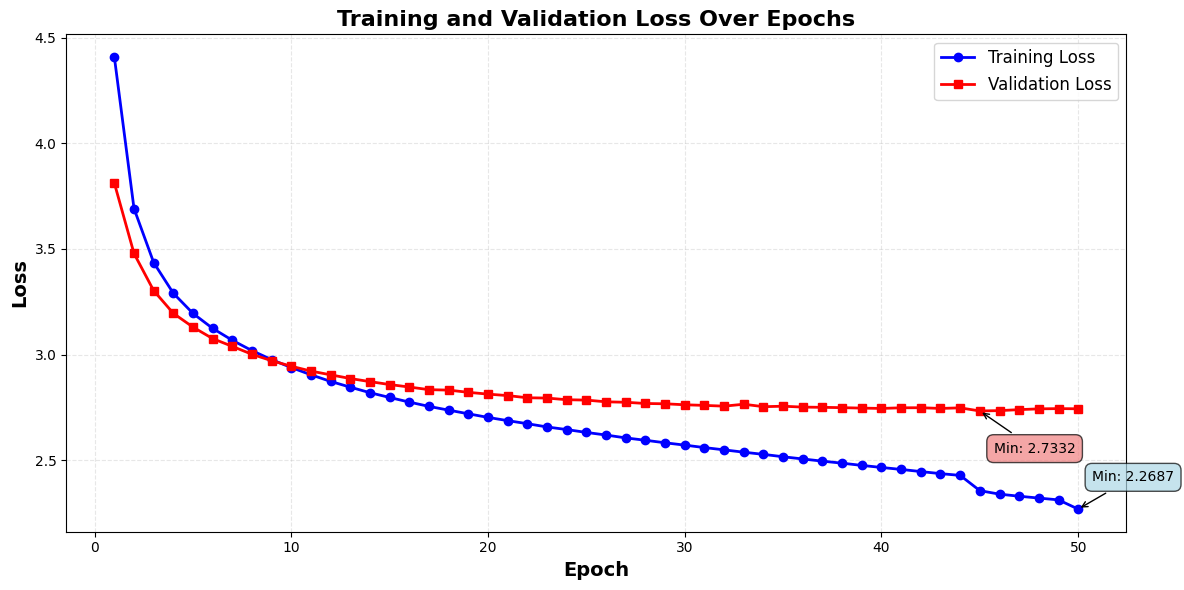


LOSS SUMMARY
Final Training Loss:   2.2687
Final Validation Loss: 2.7435
Best Training Loss:    2.2687 (Epoch 50)
Best Validation Loss:  2.7332 (Epoch 45)



In [20]:
plt.figure(figsize=(12, 6))

epochs_range = range(1, len(train_losses) + 1)

plt.plot(epochs_range, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(epochs_range, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=6)

plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Training and Validation Loss Over Epochs', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.3, linestyle='--')

# Annotate minimum points
min_train_idx = train_losses.index(min(train_losses))
min_val_idx = val_losses.index(min(val_losses))

plt.annotate(f'Min: {min(train_losses):.4f}', 
            xy=(min_train_idx+1, train_losses[min_train_idx]),
            xytext=(10, 20), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.annotate(f'Min: {min(val_losses):.4f}', 
            xy=(min_val_idx+1, val_losses[min_val_idx]),
            xytext=(10, -30), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='lightcoral', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.savefig('loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print(f"LOSS SUMMARY")
print(f"{'='*60}")
print(f"Final Training Loss:   {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Training Loss:    {min(train_losses):.4f} (Epoch {min_train_idx+1})")
print(f"Best Validation Loss:  {min(val_losses):.4f} (Epoch {min_val_idx+1})")
print(f"{'='*60}\n")

# load best model

In [21]:
checkpoint = torch.load('best_model.pth')

model_eval = ImageCaptionModel(EMBED_SIZE, HIDDEN_SIZE, vocab_size)
model_eval.load_state_dict(checkpoint['model_state_dict'])


model_eval = model_eval.to(device)
model_eval.eval()

print(" Loaded best model from training")
print(f"  Best validation loss: {checkpoint['val_loss']:.4f}")
print(f"  From epoch: {checkpoint['epoch']+1}")

 Loaded best model from training
  Best validation loss: 2.7332
  From epoch: 45


# greedy inference

In [22]:
def calculate_precision_recall_f1(predictions, references):
    """Calculate token-level Precision, Recall, F1-score"""
    all_pred_tokens = []
    all_ref_tokens = []
    
    for pred, ref_list in zip(predictions, references):
        ref = ref_list[0]
        
        max_len = max(len(pred), len(ref))
        pred_padded = pred + ['<pad>'] * (max_len - len(pred))
        ref_padded = ref + ['<pad>'] * (max_len - len(ref))
        
        all_pred_tokens.extend(pred_padded)
        all_ref_tokens.extend(ref_padded)
    
    vocab_eval = sorted(set(all_pred_tokens + all_ref_tokens))
    token_to_id = {token: i for i, token in enumerate(vocab_eval)}
    
    pred_encoded = [token_to_id[w] for w in all_pred_tokens]
    ref_encoded = [token_to_id[w] for w in all_ref_tokens]
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        ref_encoded,
        pred_encoded,
        average='weighted',
        zero_division=0
    )
    
    return precision, recall, f1


def evaluate_model(loader, model_to_eval, use_beam_search=True, beam_width=5, num_samples=None):
    """Comprehensive evaluation with ALL required metrics"""
    model_to_eval.eval()
    predictions = []
    references = []
    
    count = 0
    max_samples = num_samples if num_samples else len(loader.dataset)
    
    print(f"Evaluating on {max_samples} samples...")
    
    with torch.no_grad():
        for feats, caps in tqdm(loader, desc="Generating captions"):
            feats = feats.to(device)
            
            for i in range(feats.size(0)):
                if count >= max_samples:
                    break
                
                img_feat = feats[i].unsqueeze(0)
                
                # Generate caption
                if use_beam_search:
                    generated = model_to_eval.generate(img_feat, method='beam', beam_width=beam_width).split()
                else:
                    generated = model_to_eval.generate(img_feat, method='greedy').split()
                
                # Get ground truth
                actual = [idx2word[idx.item()] for idx in caps[i] 
                         if idx.item() not in [word2idx["<pad>"], 
                                               word2idx["<start>"], 
                                               word2idx["<end>"]]]
                
                predictions.append(generated)
                references.append([actual])
                
                count += 1
            
            if count >= max_samples:
                break
    
    # Calculate all metrics
    print("\nCalculating metrics...\n")
    
    # BLEU Scores
    bleu1 = corpus_bleu(references, predictions, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references, predictions, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, predictions, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, predictions, weights=(0.25, 0.25, 0.25, 0.25))
    
    # METEOR Score
    meteor_scores = []
    for pred, ref in zip(predictions, references):
        try:
            score = meteor_score(ref, pred)
            meteor_scores.append(score)
        except:
            meteor_scores.append(0.0)
    avg_meteor = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0.0
    
    # Precision, Recall, F1
    precision, recall, f1 = calculate_precision_recall_f1(predictions, references)
    
    # Print results
    print("="*70)
    print(" "*20 + "EVALUATION RESULTS")
    print("="*70)
    print("\n📊 BLEU Scores:")
    print(f"   BLEU-1: {bleu1:.4f}")
    print(f"   BLEU-2: {bleu2:.4f}")
    print(f"   BLEU-3: {bleu3:.4f}")
    print(f"   BLEU-4: {bleu4:.4f}")
    
    print(f"\n🌟 METEOR Score: {avg_meteor:.4f}")
    
    print(f"\n📈 Token-Level Metrics:")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print("="*70 + "\n")
    
    return {
        'bleu1': bleu1,
        'bleu2': bleu2,
        'bleu3': bleu3,
        'bleu4': bleu4,
        'meteor': avg_meteor,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'references': references
    }


# run evaluation

In [23]:
print("="*70)
print("EVALUATING MODEL")
print("="*70)

print("\n🔍 Evaluating with Beam Search (better quality)...\n")
metrics_beam = evaluate_model(val_loader, model_eval, use_beam_search=True, beam_width=5, num_samples=1000)

print("\n" + "="*70)
print("COMPARING GREEDY VS BEAM SEARCH")
print("="*70)

print("\n🔍 Evaluating with Greedy Search on small sample...\n")
metrics_greedy = evaluate_model(val_loader, model_eval, use_beam_search=False, num_samples=200)

print("\n" + "="*70)
print("📊 GREEDY vs BEAM COMPARISON")
print("="*70)
print(f"Greedy BLEU-4: {metrics_greedy['bleu4']:.4f}")
print(f"Beam BLEU-4:   {metrics_beam['bleu4']:.4f}")
print(f"Improvement:   +{(metrics_beam['bleu4'] - metrics_greedy['bleu4']):.4f}")
print("="*70 + "\n")

EVALUATING MODEL

🔍 Evaluating with Beam Search (better quality)...

Evaluating on 1000 samples...


Generating captions:   3%|▎         | 7/249 [01:23<48:19, 11.98s/it]



Calculating metrics...

                    EVALUATION RESULTS

📊 BLEU Scores:
   BLEU-1: 0.3157
   BLEU-2: 0.1950
   BLEU-3: 0.1262
   BLEU-4: 0.0805

🌟 METEOR Score: 0.2727

📈 Token-Level Metrics:
   Precision: 0.1099
   Recall:    0.1177
   F1-Score:  0.1056


COMPARING GREEDY VS BEAM SEARCH

🔍 Evaluating with Greedy Search on small sample...

Evaluating on 200 samples...


Generating captions:   0%|          | 1/249 [00:01<07:01,  1.70s/it]


Calculating metrics...

                    EVALUATION RESULTS

📊 BLEU Scores:
   BLEU-1: 0.3394
   BLEU-2: 0.2128
   BLEU-3: 0.1407
   BLEU-4: 0.0916

🌟 METEOR Score: 0.2779

📈 Token-Level Metrics:
   Precision: 0.0893
   Recall:    0.1140
   F1-Score:  0.0965


📊 GREEDY vs BEAM COMPARISON
Greedy BLEU-4: 0.0916
Beam BLEU-4:   0.0805
Improvement:   +-0.0111



# display caption examples

CAPTION EXAMPLES

Displaying 5 random images with captions...



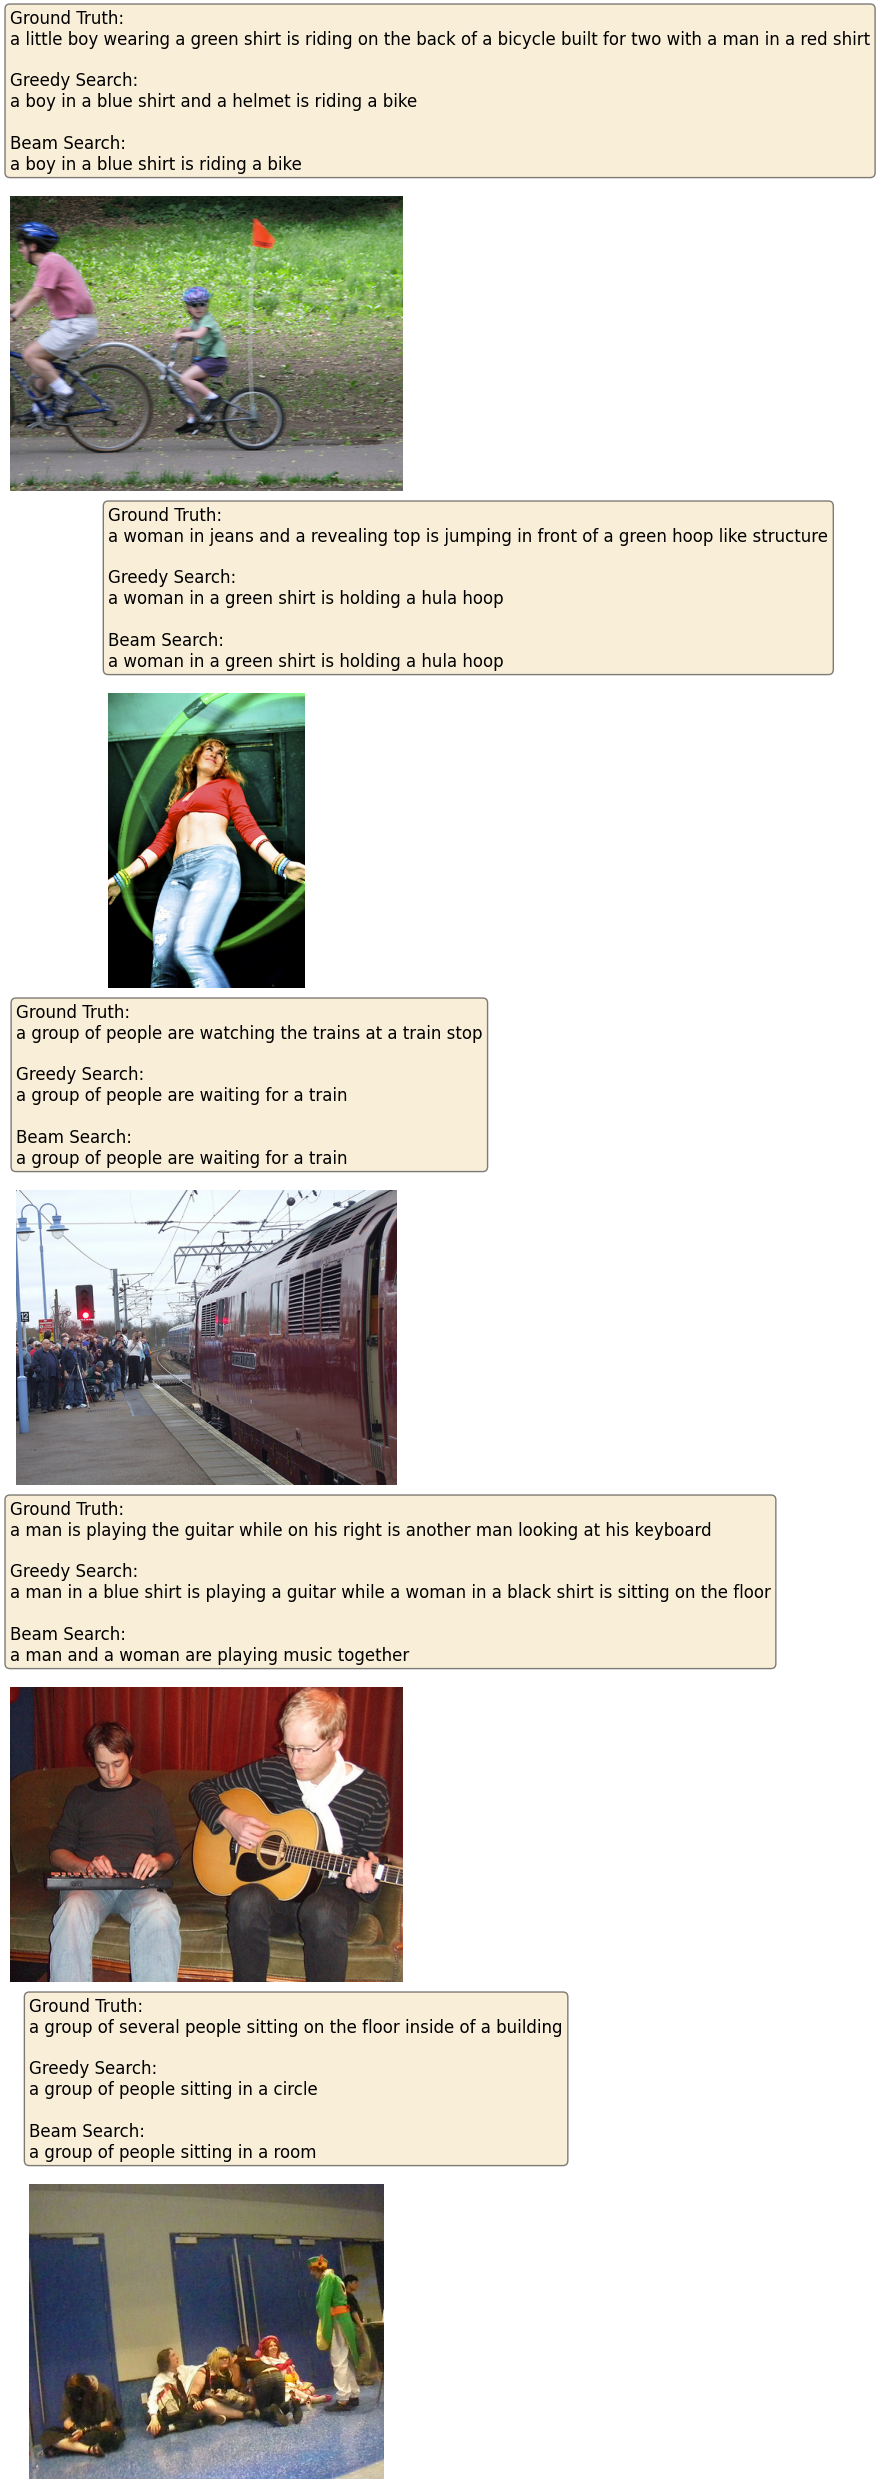

In [24]:

def display_caption_examples(num_samples=5, use_beam=True):
    """Display random images with captions"""
    sample_images = random.sample(list(features.keys()), num_samples)
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = [axes]
    
    for idx, img_name in enumerate(sample_images):
        try:
            # Load and display image
            img_path = os.path.join(IMAGE_DIR, img_name)
            img = mpimg.imread(img_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            # Get feature
            feature = torch.tensor(features[img_name]).unsqueeze(0).to(device)
            
            # Generate captions
            with torch.no_grad():
                greedy_caption = model_eval.generate(feature, method='greedy')
                if use_beam:
                    beam_caption = model_eval.generate(feature, method='beam', beam_width=5)
            
            # Get ground truth
            ground_truths = df[df['image'] == img_name]['caption'].values
            if len(ground_truths) > 0:
                gt = ground_truths[0].replace('<start>', '').replace('<end>', '').strip()
            else:
                gt = "N/A"
            
            # Create title
            title_text = f"Ground Truth:\n{gt}\n\n"
            title_text += f"Greedy Search:\n{greedy_caption}\n\n"
            if use_beam:
                title_text += f"Beam Search:\n{beam_caption}"
            
            axes[idx].set_title(title_text, fontsize=12, pad=20, loc='left', 
                              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
    
    plt.tight_layout()
    plt.savefig('caption_examples.png', dpi=300, bbox_inches='tight')
    plt.show()

print("="*70)
print("CAPTION EXAMPLES")
print("="*70)
print("\nDisplaying 5 random images with captions...\n")
display_caption_examples(num_samples=5, use_beam=True)

# metrics summary

In [25]:
metrics_df = pd.DataFrame({
    'Metric': ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'METEOR', 
               'Precision', 'Recall', 'F1-Score'],
    'Score': [
        metrics_beam['bleu1'],
        metrics_beam['bleu2'],
        metrics_beam['bleu3'],
        metrics_beam['bleu4'],
        metrics_beam['meteor'],
        metrics_beam['precision'],
        metrics_beam['recall'],
        metrics_beam['f1']
    ]
})

print("\n" + "="*50)
print("FINAL METRICS SUMMARY (for submission)")
print("="*50)
print(metrics_df.to_string(index=False))
print("="*50)

# Save to CSV
metrics_df.to_csv('evaluation_metrics.csv', index=False)
print("\n Saved metrics to evaluation_metrics.csv")


FINAL METRICS SUMMARY (for submission)
   Metric    Score
   BLEU-1 0.315733
   BLEU-2 0.194951
   BLEU-3 0.126177
   BLEU-4 0.080500
   METEOR 0.272666
Precision 0.109881
   Recall 0.117696
 F1-Score 0.105644

 Saved metrics to evaluation_metrics.csv
